In [67]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Importing Libraries

In [91]:
import numpy as np
from nltk.tokenize import word_tokenize
from mpmath import mp
mp.dps = 500
import pandas as pd
import glob 
import librosa
import imageio
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from scipy.stats import multivariate_normal
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
import math
import random
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Function for calculating accuracy

In [92]:
def calculateAccuracy(A, B):
  counter = 0;
  for i in range(0, len(A)):
    if(A[i] == B[i]):
      counter += 1
  return (counter / len(A)) * 100

Loading the path of the file

In [93]:
path = open('drive/MyDrive/Data/movieReviews.txt','r')
textFile = path.readlines()

In [94]:
labels = []
reviews = []
for i in textFile:
  i = i.strip()
  var = i.split("\t")
  labels.append(int(var[1]))
  reviews.append(var[0].strip())
labels = np.array(labels)
reviews = np.array(reviews)

TfidfVectorizer

In [95]:
TfidfVectorizerObject = TfidfVectorizer()
TfidfVectorizerData = TfidfVectorizerObject.fit_transform(reviews)
TfidfVectorizerData = TfidfVectorizerData.toarray()

In [96]:
TfidfVectorizerData.shape

(1000, 3109)

Splitting the labels into train labels and test labels

In [97]:
label = labels[0:750]
labelTest = labels[750:1000]
labelTest.shape

(250,)

Splitting the data into train and test data

In [98]:
trainData = TfidfVectorizerData[: 750]
testData = TfidfVectorizerData[750 : ]

PCA

In [99]:
pCAObject = PCA(n_components = 30)
PCAReducedTrainData = pCAObject.fit_transform(trainData)
PCAReducedDataTest = pCAObject.transform(testData)
# PCAReducedTestData.shape

Shuffling the data before splitting into training and testing

In [100]:
PCAReducedData, labelTr = shuffle(PCAReducedTrainData, label)

In [101]:
labelTrain = labelTr[0:750]

Splitting into training and testing

In [102]:
PCAReducedDataTrain = PCAReducedData[0:625]
targetTrain = labelTrain[0:625]
PCAReducedDataValidation = PCAReducedData[625:750]
targetValidation = labelTrain[625:750]
targetTrain = np.reshape(targetTrain, (625,1))
targetValidation = np.reshape(targetValidation, (125,1))

Sigmoid Function

In [103]:
def sigmoid(x):
  return (1 / (1 + np.exp(-x)))

LogisticRegression without Regularization

In [104]:
class LogisticRegression:
  def __init__(self, learningRate, batchSize, inputData, target, validationData, validationTarget, epochs):
    self.learningRate = learningRate
    self.batchSize = batchSize
    self.inputData = inputData
    self.target = target
    self.validationData = validationData
    self.validationTarget = validationTarget
    self.epochs = epochs
    self.W = np.random.rand(inputData.shape[1], 1)
    self.b = random.random()
    self.batches = []
    self.targetBatches = []
  
  def batchMaker(self):
    j=0
    for i in range(0,self.inputData.shape[0] // self.batchSize):
      j=j+1
      self.batches.append(self.inputData[i*self.batchSize:(i+1)*self.batchSize])
      self.targetBatches.append(self.target[i*self.batchSize:(i+1)*self.batchSize])
    self.batches.append(self.inputData[j*self.batchSize:self.inputData.shape[0]])
    self.targetBatches.append(self.target[j*self.batchSize:self.inputData.shape[0]])
    self.batches = np.array(self.batches)
    self.targetBatches = np.array(self.targetBatches)  
    return self.batches
  
  def getLossFunctionValue(self, data, target):
    result = 0
    for i in range(0, data.shape[0]):
      tempVar1 = np.dot(self.W.T, data[i]) + self.b
      tempVar1 = sigmoid(tempVar1)
      firstPart = target[i] * math.log(tempVar1)
      secondPart = (1 - target[i]) * math.log(1 - tempVar1)
      result += (firstPart + secondPart)
    return (result)

  def forwardPass(self, batches, target):
    batches = np.array(batches)
    derivativeW = [0]*30
    derivativeB = 0
    prediction = []
    # print(batches.shape[0])
    for i in range(0, batches.shape[0]):
      prediction.append(sigmoid(np.dot((self.W).T , batches[i]) + self.b))
    for i in range(0, batches.shape[0]):
      # print(target[i])
      derivativeB += ((prediction[i] - target[i]))
      for j in range(0,30):
        derivativeW[j] += ((prediction[i] - target[i]) * batches[i][j])
    return derivativeW, derivativeB

  def backwardPass(self, derW, derb):
    derW = np.array(derW)
    self.W = self.W - (self.learningRate * derW)
    self.b = self.b - (self.learningRate * derb)
    

  def gradientDescent(self):
    for i in range(self.batches.shape[0]):
      derW, derb = self.forwardPass(self.batches[i], self.targetBatches[i])
      derW = np.reshape(derW, (30,1))
      self.backwardPass(derW, derb)

  def plotter(self, lossFun, flag, count):
    lossFun = -1 * np.array(lossFun)
    u = np.arange(start=1, stop= count + 1, step=1)
    plt.xlabel('Epoch number')
    plt.ylabel('Loss Function')
    if flag == 0:
      plt.title('Loss function for Train data')
    else:
      plt.title('Loss function for Validation data')
    plt.plot(u,lossFun)
    plt.show()

  def train(self):
    self.batchMaker()
    trainPlot = []
    validationPlot = []
    for i in range(self.epochs):
      self.gradientDescent()
      trainPlot.append(self.getLossFunctionValue(self.inputData, self.target))
      validationPlot.append(self.getLossFunctionValue(self.validationData, self.validationTarget))
    self.plotter(trainPlot, 0, self.epochs)
    print()
    self.plotter(validationPlot, 1, self.epochs)  

  def predict(self, data):
    prediction = []
    for i in range(0, data.shape[0]):
      tempVar1 = sigmoid(np.dot((self.W).T , data[i]) + self.b)
      if (tempVar1 >= 0.5):
        prediction.append(1)
      else:
        prediction.append(0)
    return prediction

Different batch size, learning rate, and regularization parameter

In [105]:
batchSize = [32, 64, 128]
learningRate = [1e-3, 1e-2, 1e-1]
regularization =[1e-2, 1e-1, 1]

Running logistic regression without regularization for different batch sizes, leraning rate.
Predicting the labels and calculative the accuracy for the same

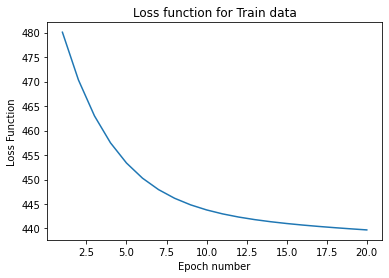

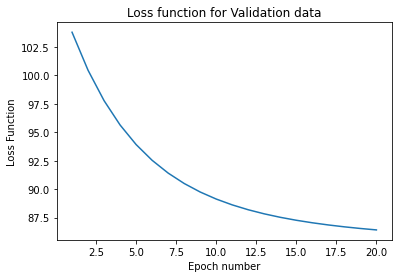

Batch Size: 32, Learning Rate: 0.001
##################################################################


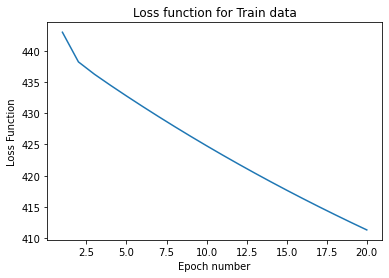

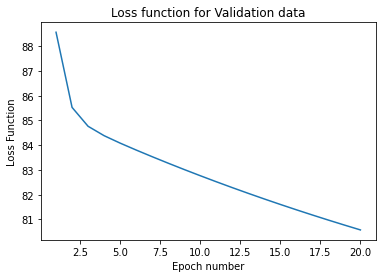

Batch Size: 32, Learning Rate: 0.01
##################################################################


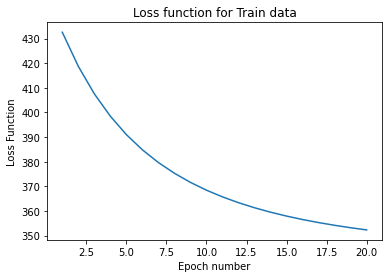

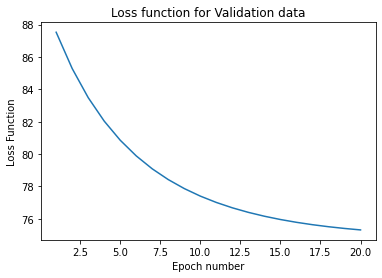

Batch Size: 32, Learning Rate: 0.1
##################################################################


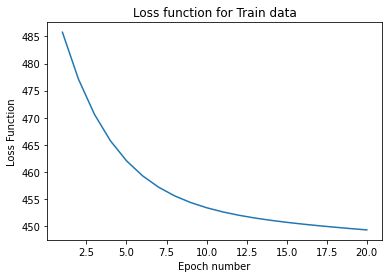

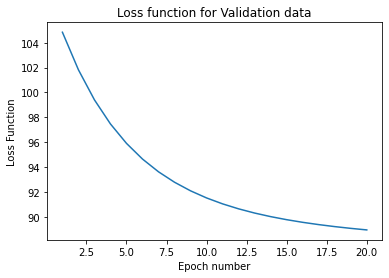

Batch Size: 64, Learning Rate: 0.001
##################################################################


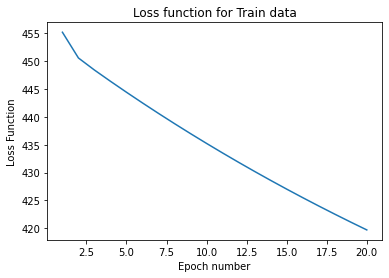

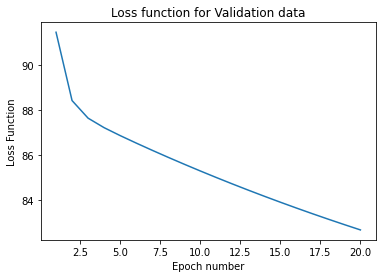

Batch Size: 64, Learning Rate: 0.01
##################################################################


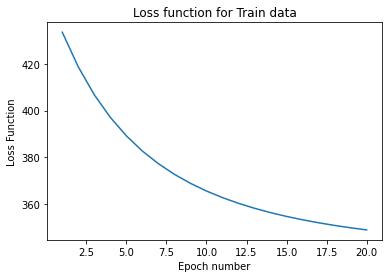

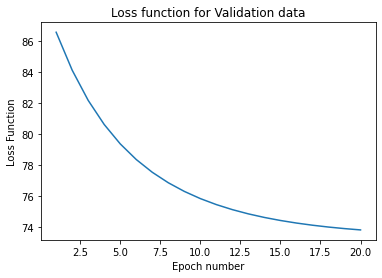

Batch Size: 64, Learning Rate: 0.1
##################################################################


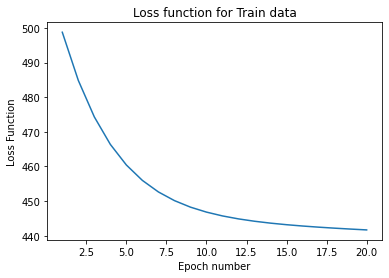

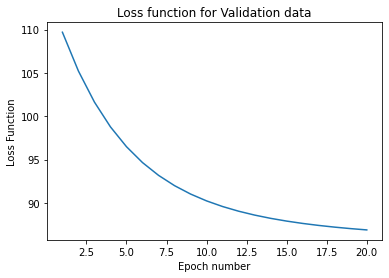

Batch Size: 128, Learning Rate: 0.001
##################################################################


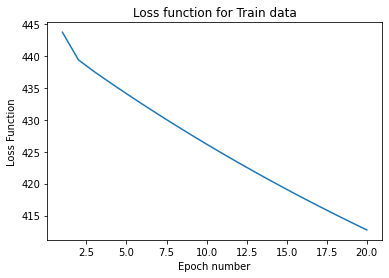

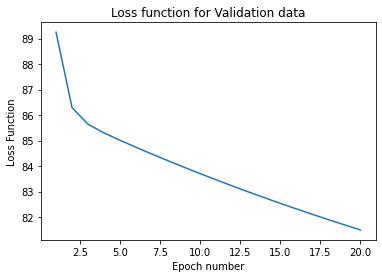

Batch Size: 128, Learning Rate: 0.01
##################################################################


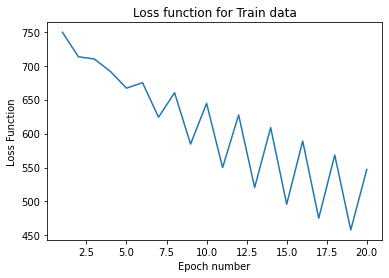

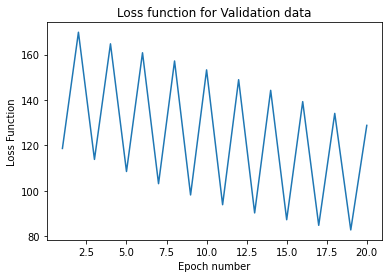

Batch Size: 128, Learning Rate: 0.1
##################################################################
Maximum Accuracy: 65.60000000000001


In [106]:
accuracies = []
for i in batchSize:
    for j in learningRate:
        LogisticRegressionObject = LogisticRegression(j, i, PCAReducedDataTrain, targetTrain, PCAReducedDataValidation, targetValidation, 20)
        
        LogisticRegressionObject.train()
        predictedlabel = LogisticRegressionObject.predict(PCAReducedDataTest)
        acc = calculateAccuracy(predictedlabel, labelTest)
        accuracies.append(acc)
        print(f'Batch Size: {i}, Learning Rate: {j}')
        # print(f'Accuracy : {acc}')
        print("##################################################################")
print(f'Maximum Accuracy: {max(accuracies)}')
# , Avg Accuracy: {sum(accuracies)/9}

**Logistic Regression with Regularization**

In [107]:
class LogisticRegressionWithRegularization:
  def __init__(self, learningRate, regularizationParameter, batchSize, inputData, target, validationData, validationTarget, epochs):
    self.learningRate = learningRate
    self.regularizationParameter = regularizationParameter
    self.batchSize = batchSize
    self.inputData = inputData
    self.target = target
    self.validationData = validationData
    self.validationTarget = validationTarget
    self.epochs = epochs
    self.W = np.random.rand(inputData.shape[1], 1)
    self.b = random.random()
    self.batches = []
    self.targetBatches = []
  
  def batchMaker(self):
    j=0
    for i in range(0,self.inputData.shape[0] // self.batchSize):
      j=j+1
      self.batches.append(self.inputData[i*self.batchSize:(i+1)*self.batchSize])
      self.targetBatches.append(self.target[i*self.batchSize:(i+1)*self.batchSize])
    self.batches.append(self.inputData[j*self.batchSize:self.inputData.shape[0]])
    self.targetBatches.append(self.target[j*self.batchSize:self.inputData.shape[0]])
    self.batches = np.array(self.batches)
    self.targetBatches = np.array(self.targetBatches)  
    return self.batches
  
  def getLossFunctionValue(self, data, target):
    result = 0
    for i in range(0, data.shape[0]):
      tempVar1 = np.dot(self.W.T, data[i]) + self.b
      tempVar1 = sigmoid(tempVar1)
      firstPart = target[i] * math.log(tempVar1)
      secondPart = (1 - target[i]) * math.log(1 - tempVar1)
      result += (firstPart + secondPart)
    temp = self.regularizationParameter * (self.W * self.W)
    return (result + temp[0])

  def forwardPass(self, batches, target):
    batches = np.array(batches)
    derivativeW = [0]*30
    derivativeB = 0
    prediction = []
    # print(batches.shape[0])
    for i in range(0, batches.shape[0]):
      # print(sigmoid(np.dot((self.W).T , batches[i]) + self.b))
      prediction.append(sigmoid(np.dot((self.W).T , batches[i]) + self.b))
    for i in range(0, batches.shape[0]):
      # print(target[i])
      derivativeB += ((prediction[i] - target[i]))
      for j in range(0,30):
        derivativeW[j] += ((prediction[i] - target[i]) * batches[i][j])
    return derivativeW, derivativeB

  def backwardPass(self, derW, derb):
    derW = np.array(derW)
    self.W = self.W - (self.learningRate * (derW + self.regularizationParameter * self.W))
    self.b = self.b - (self.learningRate * derb)
    

  def gradientDescent(self):
    for i in range(self.batches.shape[0]):
      derW, derb = self.forwardPass(self.batches[i], self.targetBatches[i])
      derW = np.reshape(derW, (30,1))
      self.backwardPass(derW, derb)

  def plotter(self, lossFun, flag, count):
    lossFun = -1 * np.array(lossFun)
    u = np.arange(start=1, stop= count+1, step=1)
    plt.xlabel('Epoch number')
    plt.ylabel('Loss Function')
    if flag == 0:
      plt.title('Loss function for Train data')
    else:
      plt.title('Loss function for Validation data')
    plt.plot(u,lossFun)
    plt.show()

  def train(self):
    self.batchMaker()
    trainPlot = []
    validationPlot = []
    for i in range(self.epochs):
      self.gradientDescent()
      trainPlot.append(self.getLossFunctionValue(self.inputData, self.target))
      validationPlot.append(self.getLossFunctionValue(self.validationData, self.validationTarget))
    self.plotter(trainPlot, 0, self.epochs)
    print()
    self.plotter(validationPlot, 1, self.epochs)  

  def predict(self, data):
    prediction = []
    for i in range(0, data.shape[0]):
      tempVar1 = sigmoid(np.dot((self.W).T , data[i]) + self.b)
      if (tempVar1 >= 0.5):
        prediction.append(1)
      else:
        prediction.append(0)
    return prediction

Running the logistic regression with regularization for different batch sizes, learning rate, and regularization parameter.

Predicting the label for output data and calculating the accuracy for the same.

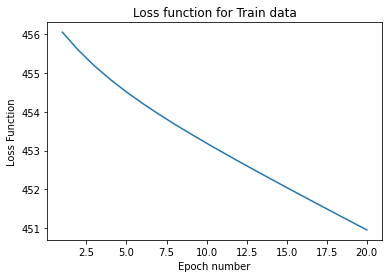

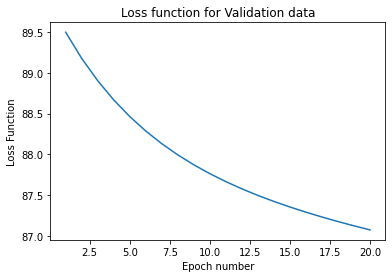

Batch Size: 32, Learning Rate: 0.001, Regularization Parameter: 0.01
############################################################################################


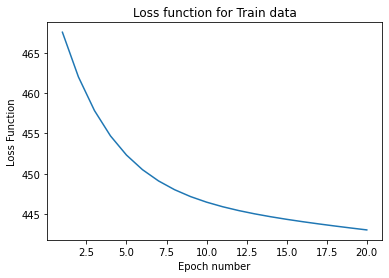

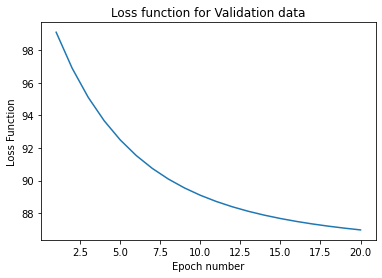

Batch Size: 32, Learning Rate: 0.001, Regularization Parameter: 0.1
############################################################################################


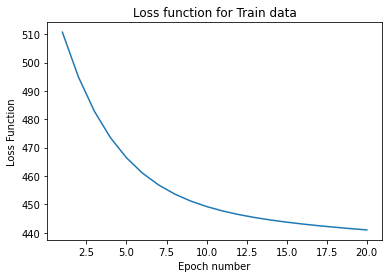

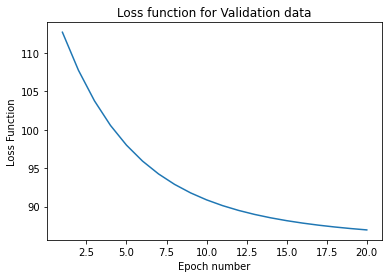

Batch Size: 32, Learning Rate: 0.001, Regularization Parameter: 1
############################################################################################


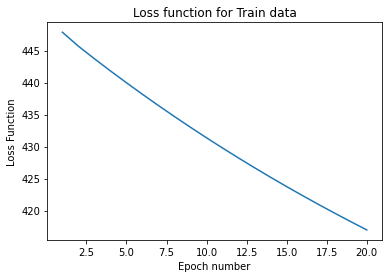

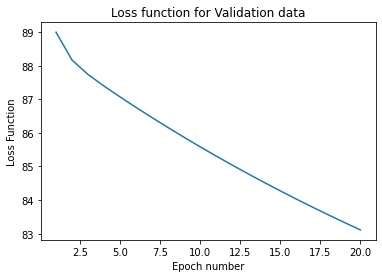

Batch Size: 32, Learning Rate: 0.01, Regularization Parameter: 0.01
############################################################################################


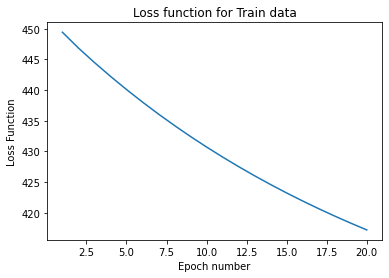

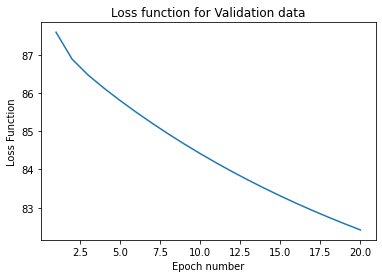

Batch Size: 32, Learning Rate: 0.01, Regularization Parameter: 0.1
############################################################################################


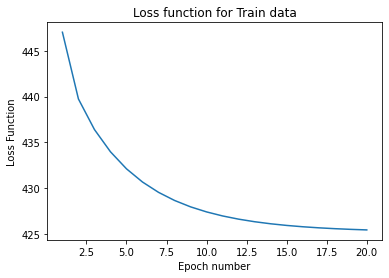

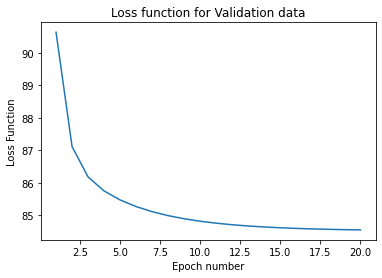

Batch Size: 32, Learning Rate: 0.01, Regularization Parameter: 1
############################################################################################


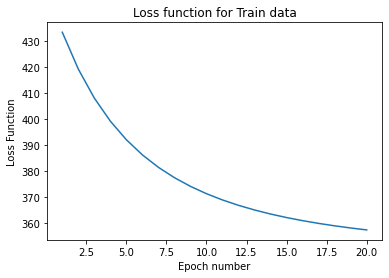

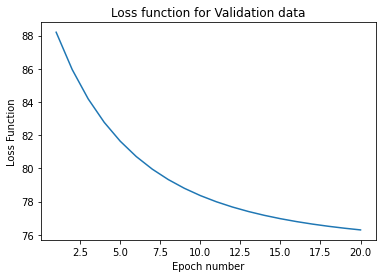

Batch Size: 32, Learning Rate: 0.1, Regularization Parameter: 0.01
############################################################################################


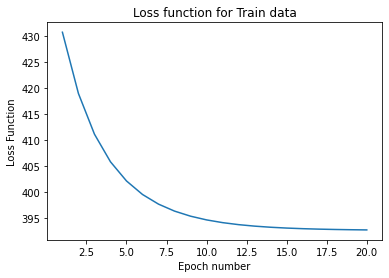

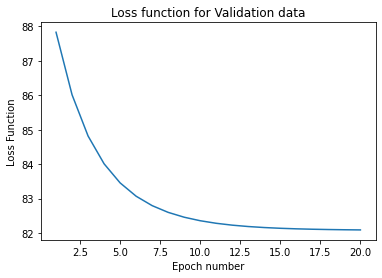

Batch Size: 32, Learning Rate: 0.1, Regularization Parameter: 0.1
############################################################################################


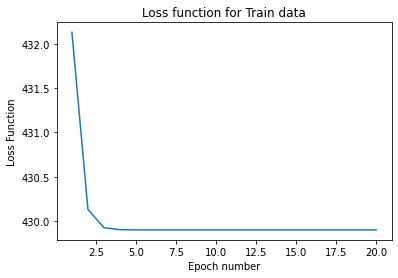

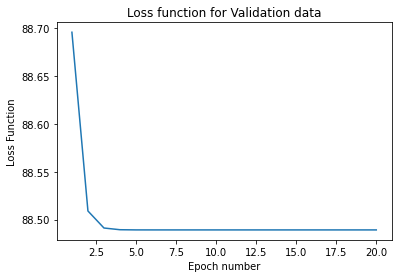

Batch Size: 32, Learning Rate: 0.1, Regularization Parameter: 1
############################################################################################


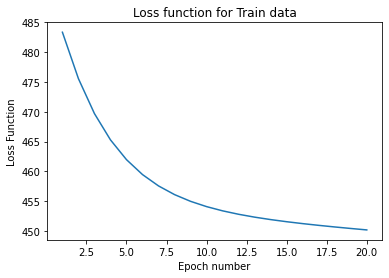

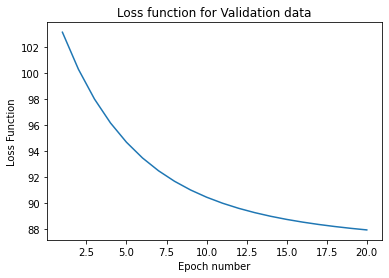

Batch Size: 64, Learning Rate: 0.001, Regularization Parameter: 0.01
############################################################################################


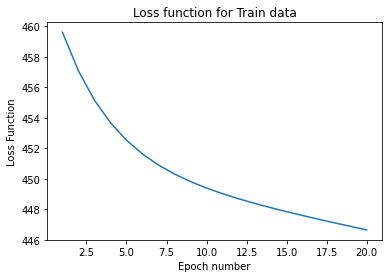

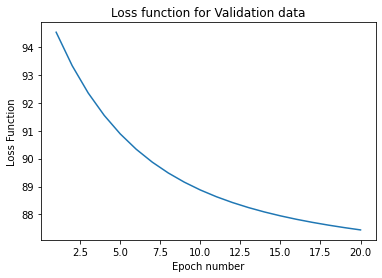

Batch Size: 64, Learning Rate: 0.001, Regularization Parameter: 0.1
############################################################################################


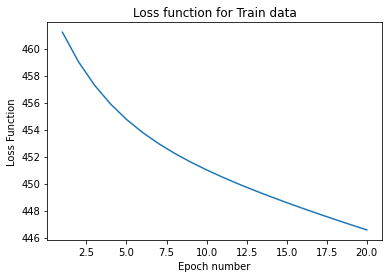

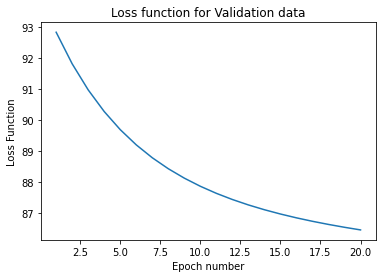

Batch Size: 64, Learning Rate: 0.001, Regularization Parameter: 1
############################################################################################


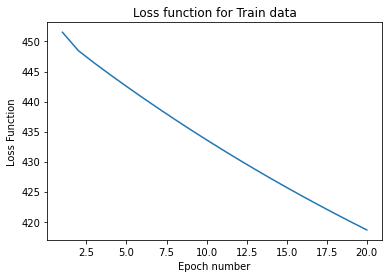

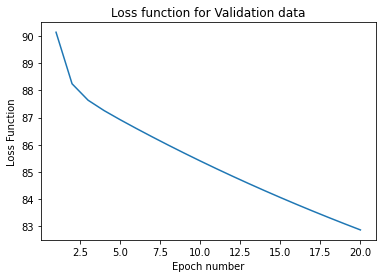

Batch Size: 64, Learning Rate: 0.01, Regularization Parameter: 0.01
############################################################################################


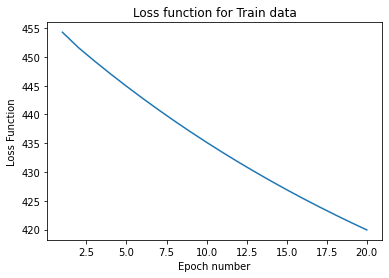

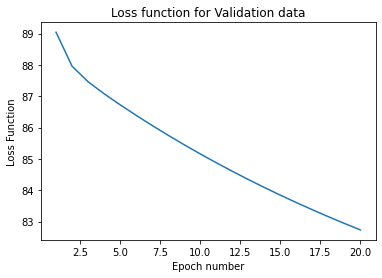

Batch Size: 64, Learning Rate: 0.01, Regularization Parameter: 0.1
############################################################################################


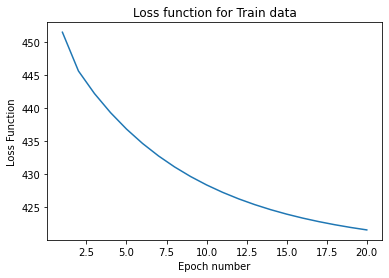

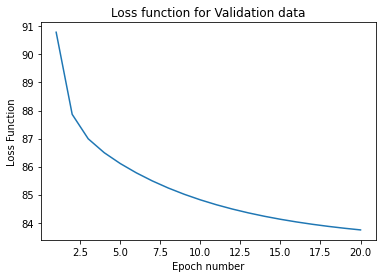

Batch Size: 64, Learning Rate: 0.01, Regularization Parameter: 1
############################################################################################


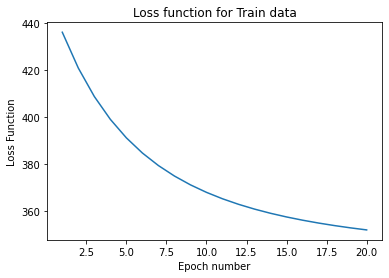

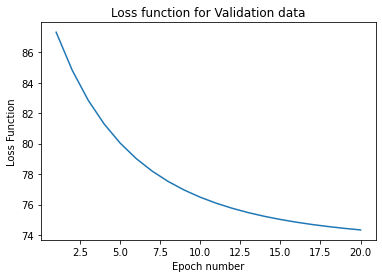

Batch Size: 64, Learning Rate: 0.1, Regularization Parameter: 0.01
############################################################################################


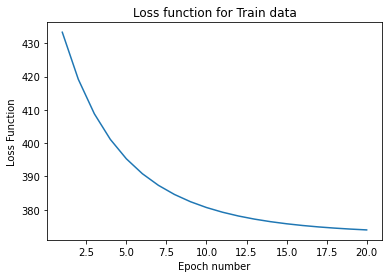

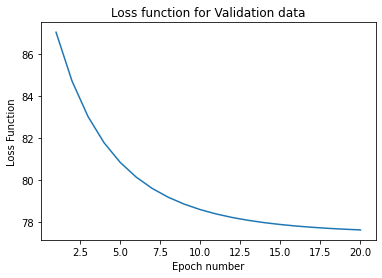

Batch Size: 64, Learning Rate: 0.1, Regularization Parameter: 0.1
############################################################################################


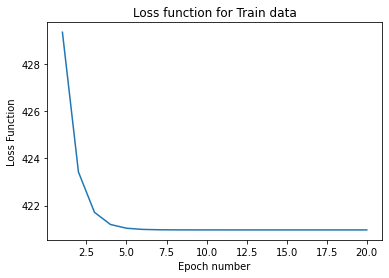

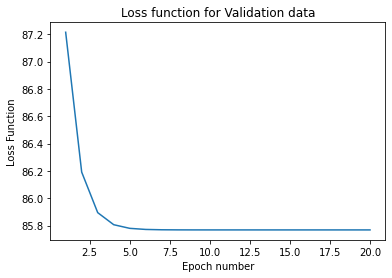

Batch Size: 64, Learning Rate: 0.1, Regularization Parameter: 1
############################################################################################


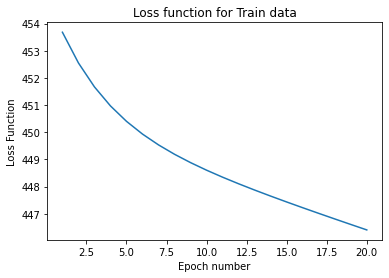

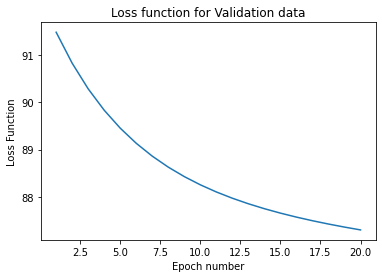

Batch Size: 128, Learning Rate: 0.001, Regularization Parameter: 0.01
############################################################################################


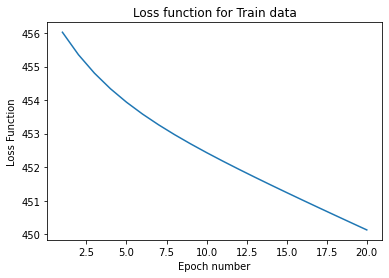

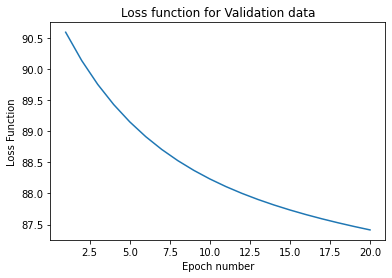

Batch Size: 128, Learning Rate: 0.001, Regularization Parameter: 0.1
############################################################################################


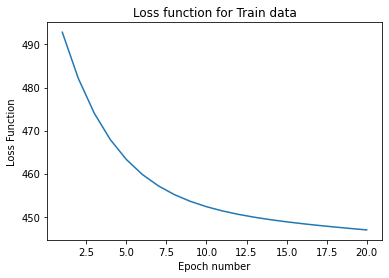

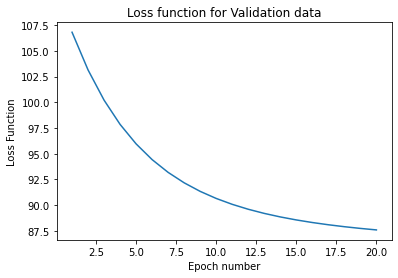

Batch Size: 128, Learning Rate: 0.001, Regularization Parameter: 1
############################################################################################


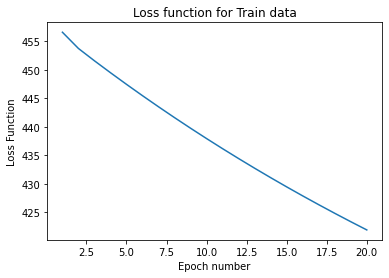

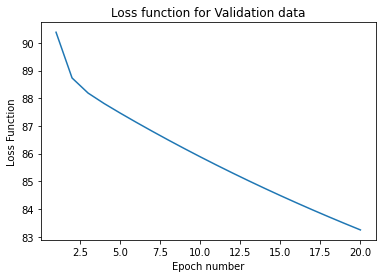

Batch Size: 128, Learning Rate: 0.01, Regularization Parameter: 0.01
############################################################################################


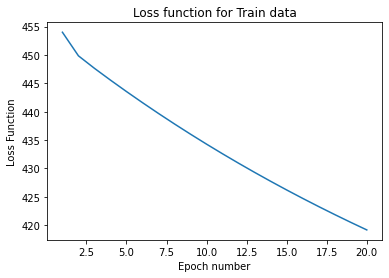

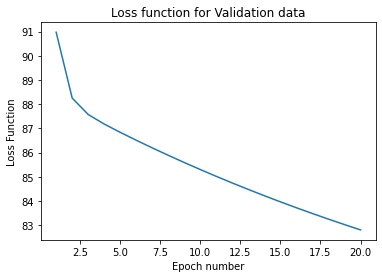

Batch Size: 128, Learning Rate: 0.01, Regularization Parameter: 0.1
############################################################################################


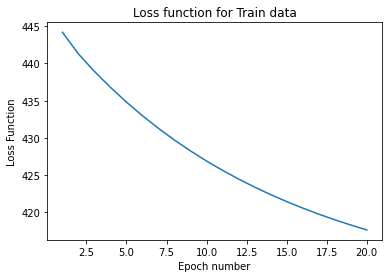

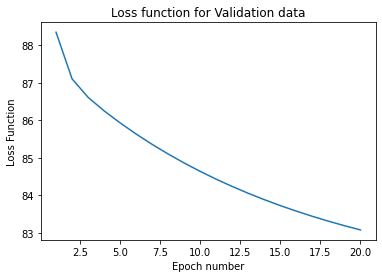

Batch Size: 128, Learning Rate: 0.01, Regularization Parameter: 1
############################################################################################


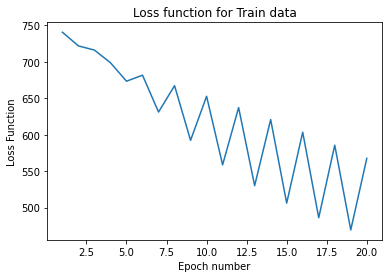

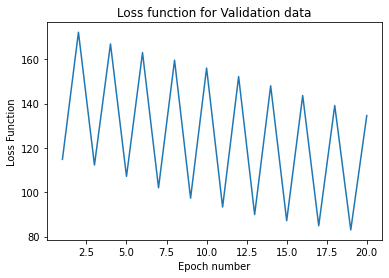

Batch Size: 128, Learning Rate: 0.1, Regularization Parameter: 0.01
############################################################################################


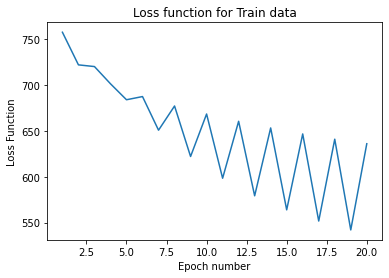

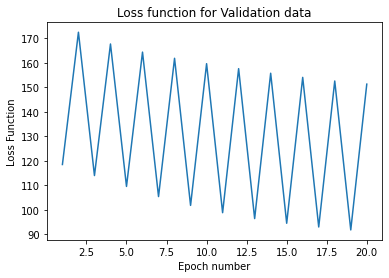

Batch Size: 128, Learning Rate: 0.1, Regularization Parameter: 0.1
############################################################################################


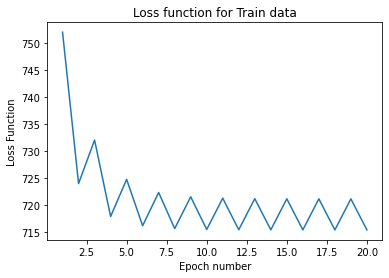

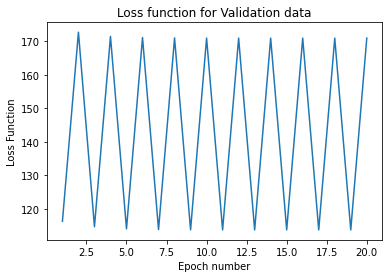

Batch Size: 128, Learning Rate: 0.1, Regularization Parameter: 1
############################################################################################
Maximum Accuracy: 68.4


In [108]:
accuracies = []
for i in batchSize:
    for j in learningRate:
        for k in regularization:
            LogisticRegressionWithRegularizationObject = LogisticRegressionWithRegularization(
            j, 
            k , 
            i, 
            PCAReducedDataTrain, 
            targetTrain, 
            PCAReducedDataValidation, 
            targetValidation, 
            20)            
            LogisticRegressionWithRegularizationObject.train()
            predictedlabelReg = LogisticRegressionWithRegularizationObject.predict(PCAReducedDataTest)
            acc = calculateAccuracy(predictedlabelReg, labelTest)
            accuracies.append(acc)
            # print(f'Accuracy : {acc}')
            print(f'Batch Size: {i}, Learning Rate: {j}, Regularization Parameter: {k}')
            print("############################################################################################")
print(f'Maximum Accuracy: {max(accuracies)}')
# , Avg Accuracy: {sum(accuracies)/27}

# Maximum Accuracy 


# 1.   Logistic Regression without regularization : 65.6
# 2.   Logistic Regression with regularization : 68.4



# While implementing logistic regression without regularization we found our algo is suffering from overfitting(train error low, validation error high, Regularization Parameter is low)  when


# *   Batch Size : 128
# *   Learning Rate : 0.1




# While implementing logistic regression with regularization we found our algo is suffering from overfitting(train error low, validation error high, Regularization Parameter is low) when


# *   Batch Size : 128
# *   Learning Rate : 0.1
# *   Regularization Parameter : 0.01/0.1